In [1]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
import sqlite3
import sqllite_handler
import copy

/Users/gokberk/miniconda3/envs/ml4hc_project2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### TOPIC MODELING w/ LDA and Dynamic LDA (transfer this into .py file)

#### a) preprocessing

In [2]:
# LDA topic modeling

import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.ldaseqmodel import LdaSeqModel
import spacy
import pickle
import math
import ray
ray.init(num_cpus=12)

pyLDAvis.enable_notebook()
nlp = spacy.load('en_core_web_sm')

In [4]:
tables_path = 'tables/tables_52_88/'
plots_path = 'plots/plots_52_88/'
name_extension = '_52_88_lda_entremoved_len3'

doc_df = pd.read_csv(tables_path+'doc.csv')
#doc_df = doc_df[doc_df['subtype']!='editorial-note']
free_text_list = doc_df['text'].values
free_text_list = list(map(lambda x: ' ' if not x or (isinstance(x, float) and math.isnan(x)) else x, free_text_list))

In [5]:
@ray.remote
def preprocess(row):
    return [t.lemma_.lower() for t in nlp(row) if not t.is_punct and not t.is_stop and t.ent_iob_=='O' and len(t.text)>=3]
# and t.pos_ in ['PROPN','NOUN']

futures = [preprocess.remote(row) for row in free_text_list]
processed_free_text_list = ray.get(futures)

2023-03-31 16:28:29,637	WARNING worker.py:1257 -- Warning: The remote function __main__.preprocess is very large (16 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


In [ ]:
with open(tables_path+"lda_processed_entremoved_len3_free_text_list", "wb") as fp:
    pickle.dump(processed_free_text_list, fp)

In [5]:
# for dynamic lda
year_list = list(map(lambda x: int(x),doc_df['year']))
year_text_tuple = list(zip(year_list, processed_free_text_list))
year_text_tuple = sorted(year_text_tuple, key=lambda x: x[0])
sorted_year_list = list(map(lambda x: x[0],year_text_tuple))
sorted_text_list = list(map(lambda x: x[1],year_text_tuple))

#### b.1) gensim

In [6]:
# LDA
dictionary = Dictionary(processed_free_text_list)

dictionary.filter_extremes(keep_n=10000)

doc_term_matrix = [dictionary.doc2bow(doc) for doc in processed_free_text_list]

lda = LdaModel(corpus = doc_term_matrix, id2word=dictionary, num_topics=30)

gensimvis.prepare(lda, doc_term_matrix, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
12     0.127030  0.037565       1        1  9.274050
29    -0.025619  0.077944       2        1  6.274509
17    -0.201994 -0.042956       3        1  6.073815
18    -0.037899  0.045297       4        1  5.271811
22    -0.129346  0.033152       5        1  4.765971
21    -0.101367 -0.011021       6        1  4.337022
15     0.122870 -0.049550       7        1  4.209142
27    -0.011762 -0.001054       8        1  4.056872
10     0.024470  0.013289       9        1  4.047227
4      0.167446  0.010249      10        1  3.996227
5     -0.152043 -0.008399      11        1  3.942832
13     0.031347  0.041321      12        1  3.767231
9      0.138189  0.081849      13        1  3.722769
8      0.115431  0.045924      14        1  3.496913
2      0.030488  0.048744      15        1  3.048903
1      0.146993 -0.145274      16        1  2.844345
26    -0.074981 -0.107431      17        1  2.833736
25     0.022543 -0.106522      18        1  2.830132
11    -0.028444 -0.100770      19        1  2.748677
3     -0.105976 -0.052107      20        1  2.504680
23    -0.087913  0.036886      21        1  2.082349
20    -0.078159  0.003613      22        1  2.031910
6      0.037139  0.093519      23        1  2.024806
24    -0.009145  0.014961      24        1  1.979278
28     0.117125 -0.084110      25        1  1.956588
14     0.060265 -0.169564      26        1  1.693372
0     -0.023929  0.081564      27        1  1.386733
19     0.076435  0.151466      28        1  1.344475
16    -0.091569  0.050541      29        1  1.186548
7     -0.057623  0.010873      30        1  0.267079, topic_info=           Term          Freq         Total Category  logprob  loglift
373         mr.  47076.000000  47076.000000  Default  30.0000  30.0000
442   secretary  51223.000000  51223.000000  Default  29.0000  29.0000
140         say  46002.000000  46002.000000  Default  28.0000  28.0000
1378        oil  14555.000000  14555.000000  Default  27.0000  27.0000
367    minister  26844.000000  26844.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
82        issue     63.648122  28791.278939  Topic30  -5.6744  -0.1891
351        line     61.029055  20033.634689  Topic30  -5.7165   0.1316
477        talk     58.610767  25117.952879  Topic30  -5.7569  -0.1350
119   political     58.336989  23286.145252  Topic30  -5.7616  -0.0640
167        tell     56.884552  23338.500220  Topic30  -5.7868  -0.0915

[2330 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
4251      3  0.112526  10:00
4251      5  0.843945  10:00
5009      6  0.791973   1954
5009     10  0.049498   1954
5009     12  0.049498   1954
...     ...       ...    ...
1071     25  0.000346   zone
1071     26  0.098180   zone
1071     27  0.000691   zone
1071     29  0.000346   zone
1071     30  0.000346   zone

[21694 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 30, 18, 19, 23, 22, 16, 28, 11, 5, 6, 14, 10, 9, 3, 2, 27, 26, 12, 4, 24, 21, 7, 25, 29, 15, 1, 20, 17, 8])

In [ ]:
# dynamic LDA (Gensim's dynamic lda is too slow. this code below will not terminate)
dictionary = Dictionary(sorted_text_list)

dictionary.filter_extremes(keep_n=100)

doc_term_matrix = [dictionary.doc2bow(doc) for doc in sorted_text_list]

time_slice = pd.Series(sorted_year_list).value_counts(sort=False).values

ldaseq = LdaSeqModel(corpus = doc_term_matrix, time_slice=list(time_slice), id2word=dictionary, num_topics=5)

#### b.2) tomotopy

In [ ]:
# LDA
import tomotopy as tp
import sys
plots_path = 'plots/plots_52_88/'

# define model
mdl = tp.LDAModel(k=100,tw=tp.TermWeight.ONE)

# add documents
for txt in processed_free_text_list:
    mdl.add_doc(txt)

# train model
mdl.train(100)

# save into file
mdl.save(tables_path+'lda_topic_model_entremoved_len3.bin')

topic_term_dists = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
vocab = list(mdl.used_vocabs)
term_frequency = mdl.used_vocab_freq

prepared_data = pyLDAvis.prepare(topic_term_dists, doc_topic_dists, doc_lengths, vocab, term_frequency,start_index=0,sort_topics=False)
pyLDAvis.save_html(prepared_data, plots_path+'lda_entremoved.html')

In [ ]:
lda_topic_descp = {} # topic: top n words

for idx in range(mdl.k):
    results = mdl.get_topic_words(idx)
    topic_words = list(map(lambda x: x[0],results))
    lda_topic_descp[str(idx)] = " - ".join(topic_words)

In [ ]:
doc_topic_dict = {} # id_to_text : assigned_topic

id_to_text_list = doc_df['id_to_text'].values
doc_insts = mdl.docs

cnt = 0
for idx in range(len(processed_free_text_list)):

    temp_txt = processed_free_text_list[idx]
    if len(temp_txt)!=0:
        results = doc_insts[cnt].get_topics()
        assigned_topic = str(results[0][0])
        doc_topic_dict[id_to_text_list[idx]] = assigned_topic
        cnt += 1

In [ ]:
name_extension = '_52_88_lda_entremoved_len3'

topic_desc_df = pd.DataFrame(lda_topic_descp.items(),columns=['Name','Top_n_words'])
doc_topic_df = pd.DataFrame(doc_topic_dict.items(),columns=['id_to_text','assigned_topic'])

topic_desc_df.to_parquet(tables_path+'topic_descp'+name_extension+'.parquet')
doc_topic_df.to_parquet(tables_path+'doc_topic'+name_extension+'.parquet')

In [ ]:
# transfer finished.

In [14]:
# dynamic LDA (very fast)

# define model
mdl = tp.DTModel(k=30, t=len(np.unique(sorted_year_list)), tw=tp.TermWeight.ONE)

# add documents
for idx,txt in enumerate(sorted_text_list):
    time_pt = sorted_year_list[idx]-min(sorted_year_list)
    mdl.add_doc(words=txt, timepoint=time_pt)

# train model
mdl.train(100)

2023-03-28 16:54:27,680	WARNING worker.py:469 -- The driver may not be able to keep up with the stdout/stderr of the workers. To avoid forwarding logs to the driver, use 'ray.init(log_to_driver=False)'.


In [36]:
for t in range(mdl.num_timepoints):
    results = mdl.get_topic_words(topic_id=15,timepoint=t,top_n=5)
    print(f't:{t}, top words: {list(map(lambda x: x[0],results))}')

t:0, top words: ['time', 'standard', 'ask', 'give', 'feel']
t:1, top words: ['give', 'ask', 'feel', 'conversation', 'chance']
t:2, top words: ['ask', 'give', 'feel', 'wish', 'say']
t:3, top words: ['say', 'ask', 'government', 'feel', 'war']
t:4, top words: ['ask', 'decision', 'feel', 'result', 'accept']
t:5, top words: ['agreement', 'agree', 'position', 'ask', 'accept']
t:6, top words: ['ask', 'agree', 'position', 'agreement', 'secretary']
t:7, top words: ['secretary', 'ask', 'agree', 'position', 'agreement']
t:8, top words: ['secretary', 'state', 'ask', 'negotiation', 'agree']
t:9, top words: ['secretary', 'state', 'know', 'right', 'intervene']
t:10, top words: ['state', 'secretary', 'talk', 'nature', 'salt']
t:11, top words: ['state', 'oil', 'instruction', 'multiple', 'provide']
t:12, top words: ['oil', 'state', 'subject', 'statement', 'company']
t:13, top words: ['oil', 'market', 'supply', 'world', 'state']
t:14, top words: ['oil', 'concern', 'price', 'time', 'believe']


### below is for parallel removal of named entities from free texts. (save in original code)

In [1]:
import pandas as pd
import numpy as np
import spacy
import pickle
import math
import ray
ray.init(num_cpus=12)

nlp = spacy.load('en_core_web_sm')

name_extension = '_52_88_entremoved'

/Users/gokberk/miniconda3/envs/ml4hc_project2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/gokberk/miniconda3/envs/ml4hc_project2/lib/python3.9/site-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.5.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [2]:
@ray.remote
def remove_entities(txt):
    document = nlp(txt)

    edited_txt = ""
    for token in document:
        
        if token.ent_iob_=='O':
            if token.whitespace_:
                edited_txt += token.text+ ' '
            else:
                edited_txt += token.text
    
    return edited_txt

In [3]:
doc_df = pd.read_csv('tables/tables_52_88/doc.csv')
free_text_list = doc_df['text'].values
free_text_list = list(map(lambda x: ' ' if not x or (isinstance(x, float) and math.isnan(x)) else x, free_text_list))

futures = [remove_entities.remote(txt) for txt in free_text_list]
free_text_list = ray.get(futures)
print('entities removed from free texts.')

with open("tables/tables_52_88/free_text_list"+name_extension, "wb") as fp:
    pickle.dump(free_text_list, fp)

2023-03-27 13:39:04,684	WARNING worker.py:1257 -- Warning: The remote function __main__.remove_entities is very large (16 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


entities removed from free texts.


### KEYWORD EXTRACTION

In [1]:
import spacy
import pandas as pd
import yake
import math
import ray
ray.init(num_cpus=13)

nlp = spacy.load('en_core_web_sm')

/Users/gokberk/miniconda3/envs/ml4hc_project2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/gokberk/miniconda3/envs/ml4hc_project2/lib/python3.9/site-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.5.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [4]:
doc_df = pd.read_csv('tables/tables_69_76/doc.csv')
free_text_list = doc_df['text'].values
free_text_list = list(map(lambda x: ' ' if not x or (isinstance(x, float) and math.isnan(x)) else x, free_text_list))

ke = yake.KeywordExtractor(dedupLim=0.9, top=10, n=2)

In [5]:
@ray.remote
def extract_yake_keywords(txt):
    
    preprocessed_txt = " ".join([t.text.lower() for t in nlp(txt) if t.ent_iob_=='O'])

    keyw1 = list(map(lambda x:x[0],ke.extract_keywords(txt.lower())))
    keyw2 = list(map(lambda x:x[0],ke.extract_keywords(preprocessed_txt)))

    return list(set(keyw1+keyw2))

In [6]:
futures = [extract_yake_keywords.remote(txt) for txt in free_text_list]
keyword_list = ray.get(futures)
ray.shutdown()

2023-04-17 17:13:57,242	WARNING worker.py:1257 -- Warning: The remote function __main__.extract_yake_keywords is very large (16 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


### LINK PREDICTION

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
tqdm.pandas()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = SentenceTransformer('all-MiniLM-L6-v2')

new_unified_person_df_final = pd.read_parquet('tables/tables_52_88/new_unified_person_df_final.parquet')

In [3]:
descp_embd_list = []

def get_descp_embd(row):
    
    global descp_embd_list

    description_list = row['description_list']

    frus_embedding = np.mean(model.encode(description_list), axis=0)

    descp_embd_list.append(frus_embedding)

    return

In [4]:
new_unified_person_df_final.progress_apply(lambda x: get_descp_embd(x),axis=1)

100%|██████████| 13076/13076 [08:14<00:00, 26.43it/s]


0        None
1        None
2        None
3        None
4        None
         ... 
17623    None
17624    None
17625    None
17630    None
17631    None
Length: 13076, dtype: object

In [5]:
cossim_mat = cosine_similarity(descp_embd_list)

similar_persons_dict = {}

def compute_most_similar_persons(idx, top_n=10):

    global similar_persons_dict

    similar_entity_idx = np.argsort(cossim_mat[idx])[::-1][1:top_n+1]
    
    current_name_set = new_unified_person_df_final.iloc[idx].name_set
    similar_name_set = new_unified_person_df_final.iloc[similar_entity_idx].name_set.values

    similar_persons_dict[current_name_set] = similar_name_set

    return

In [6]:
for idx in tqdm(range(len(descp_embd_list))):
    compute_most_similar_persons(idx) 

100%|██████████| 13076/13076 [00:11<00:00, 1097.65it/s]


In [7]:
tables_path = 'tables/tables_52_88/'

similar_descp_persons = pd.Series(similar_persons_dict).explode().reset_index().rename(columns={'index':'source_person',0:'target_person'})
similar_descp_persons.to_parquet(tables_path+'similar_descp_persons.parquet')

In [8]:
similar_descp_persons

,source_person,target_person
0,Acheson Dean,Dulles Foster John
1,Acheson Dean,Herbert Hoover Jr.
2,Acheson Dean,B. Donold Lourie
3,Acheson Dean,H. Howland Sargeant
4,Acheson Dean,Joseph Short
...,...,...
130755,Siew Sin Tan,Cesar Virata
130756,Siew Sin Tan,Joong-chai Lee
130757,Siew Sin Tan,Chintaman Deshmukh Dwarkanath Sir
130758,Siew Sin Tan,Abdelmoneim al-Kaissouni


### EMOTIONMETER

In [11]:
import pandas as pd
import spacy
import math
import ray
ray.init(num_cpus=12)

{'node_ip_address': '127.0.0.1',
 'raylet_ip_address': '127.0.0.1',
 'redis_address': '127.0.0.1:6379',
 'object_store_address': '/tmp/ray/session_2023-04-17_00-22-10_528410_4497/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2023-04-17_00-22-10_528410_4497/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2023-04-17_00-22-10_528410_4497',
 'metrics_export_port': 58588,
 'gcs_address': '127.0.0.1:50901',
 'node_id': 'bbcaecdd5e9d94f852c98c90794b3ff0ed5895f84f64893af2868809'}

In [12]:
affection_path='emotionmeter/word_lists/affect_list.txt'
cognition_path='emotionmeter/word_lists/cognition_list.txt'

with open(affection_path, "r") as f:
    affect_list = f.readlines()
affect_list = [word.strip() for word in affect_list]
with open(cognition_path, "r") as f:
    cognition_list = f.readlines()
cognition_list = [word.strip() for word in cognition_list]

nlp = spacy.load('en_core_web_md')

In [13]:
nlp_cognition = nlp(' '.join(cognition_list))
nlp_affection = nlp(' '.join(affect_list))

@ray.remote
def compute_emotion_score(txt):

    # TODO: preprocess text
    #[t.lemma_.lower() for t in nlp(row) if not t.is_punct and not t.is_stop and t.ent_iob_=='O' and len(t.text)>=3]
    nlp_txt = nlp(txt)
    cognition_score = nlp_cognition.similarity(nlp_txt)
    affection_score = nlp_affection.similarity(nlp_txt)

    return (affection_score + 1) / (cognition_score + 1)

In [16]:
tables_path = 'tables/tables_69_76/'
doc_df = pd.read_csv(tables_path+'doc.csv')
free_text_list = doc_df['text'].values
free_text_list = list(map(lambda x: ' ' if not x or (isinstance(x, float) and math.isnan(x)) else x, free_text_list))

In [17]:
futures = [compute_emotion_score.remote(row) for row in free_text_list]
scores = ray.get(futures)

2023-04-17 00:23:00,932	WARNING worker.py:1257 -- Warning: The remote function __main__.compute_emotion_score is very large (59 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
(compute_emotion_score pid=4798) /var/folders/r_/jwmzgr6s6_762bz0h7x_qll40000gn/T/ipykernel_4497/4101040384.py:10: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
(compute_emotion_score pid=4798) /var/folders/r_/jwmzgr6s6_762bz0h7x_qll40000gn/T/ipykernel_4497/4101040384.py:11: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.


In [21]:
emotion_text_df = pd.DataFrame(data={'score':scores,'text':free_text_list})

In [30]:
emotion_text_df[emotion_text_df['score'] > .9]

,score,text
0,0.945586,HENRY A. KISSINGER BRIEFING OF WHITE HOUSE STA...
1,0.949313,SUBJECT President Nixon’s Meeting with Congres...
2,0.945725,"[Omitted here is discussion on the economy, wa..."
3,0.951938,PARTICIPANTS Soviet Ambassador Anatoli Dobryni...
4,0.912251,"On October 16, 1971, Assistant to the Presiden..."
...,...,...
19506,0.940451,PROCEEDINGS Secretary Kissinger: I see a lot o...
19507,0.976649,6802. Subject: Reply of Prime Minister to Secr...
19508,0.938745,Secretary Kissinger has given me a full report...
19509,0.938075,252353. Subj: Message From Secretary to Sadat ...


### DOC2VEC for PRESIDENTS

In [71]:
import pandas as pd
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

doc_df = pd.read_csv('tables/tables_52_88/doc.csv')
doc_df.loc[doc_df[doc_df['text'].isna()].index,'text'] = ' '

In [73]:
president_texts = doc_df.groupby('era',as_index=False).agg({'text': ' '.join})
print('text concatenated by era.')
documents = [TaggedDocument(simple_preprocess(data['text'].lower()), [data['era']]) for _,data in president_texts.iterrows()]
print('ready to fit doc2vec model.')
model = Doc2Vec(documents, vector_size=300, window=5, min_count=5, workers=14)
print('done')

text concatenated by era.
ready to fit doc2vec model.
done


In [78]:
idx_to_president = model.dv.index_to_key
party_colors = ['r','r','b','b','b','b','r','r']

president_vectors = model.dv.vectors

In [86]:
print(idx_to_president)

['Dwight D. Eisenhower', 'Gerald R. Ford', 'Harry S. Truman', 'Jimmy Carter', 'John F. Kennedy', 'Lyndon B. Johnson', 'Richard M. Nixon', 'Ronald Reagan']


In [95]:
model.dv.most_similar('Harry S. Truman')

[('Ronald Reagan', 0.8759977221488953),
 ('Dwight D. Eisenhower', 0.8237576484680176),
 ('John F. Kennedy', 0.740585446357727),
 ('Lyndon B. Johnson', 0.7193674445152283),
 ('Jimmy Carter', 0.703508734703064),
 ('Richard M. Nixon', 0.6620807647705078),
 ('Gerald R. Ford', 0.6270113587379456)]

Text(0.5, 1.0, 'President Vectors reduced by PCA')

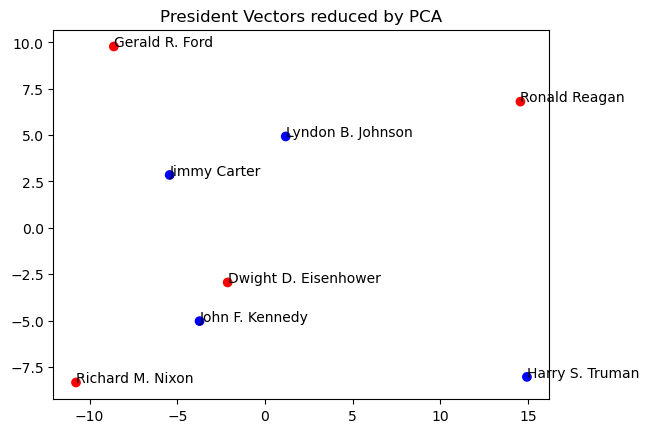

In [98]:
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, MDS
import matplotlib.pyplot as plt

pca = PCA(n_components=2)

tr_p_vec = pca.fit_transform(president_vectors)

plt.scatter(x=tr_p_vec[:,0],y=tr_p_vec[:,1],c=party_colors)

for i, txt in enumerate(idx_to_president):
    plt.annotate(txt, (tr_p_vec[i,0], tr_p_vec[i,1]))

plt.title('President Vectors reduced by PCA')